Will use device: cpu, torch dtype: torch.float32


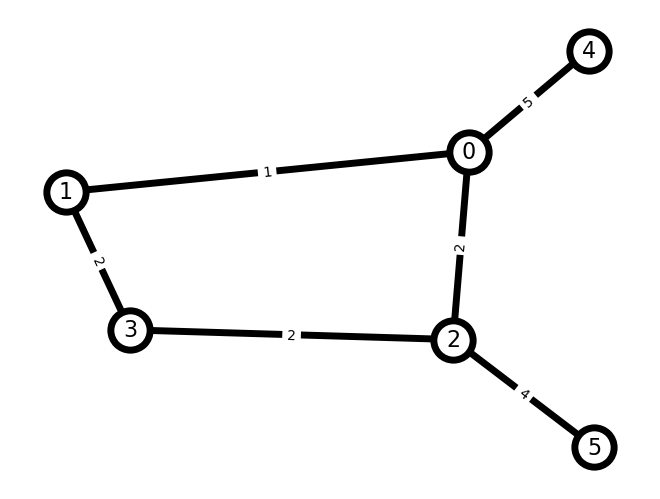

In [1]:
from networkx.algorithms.flow import shortest_augmenting_path, minimum_cut_value
import networkx as nx
import itertools
import pickle
import dgl
import torch
from collections import OrderedDict, defaultdict

from GraphCreator import *
from utils import *
from itertools import permutations
import matplotlib.pyplot as plt
import pickle

In [10]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


def open_file(obj, filename):
    '''
    Example usage "with open('./datasetItem_exp2.pkl', 'rb') as inp"
    :param obj:
    :param filename:
    :return:
    '''
    with open(filename, 'rb') as inp:
        dst = pickle.load(inp)

    return dst

In [11]:
def recursive_cut(graph, terminals):
    if len(terminals) <= 1 or graph.number_of_nodes() == 0:
        # Base case: no cut needed if only one terminal or graph is empty
        return 0, {terminals[0]: graph} if terminals else {}

    # Perform initial 2-way cut between the first two terminals
    cut_value, (part_1, part_2) = nx.minimum_cut(graph, terminals[0], terminals[1], flow_func=shortest_augmenting_path)
    graph_1, graph_2 = graph.subgraph(part_1).copy(), graph.subgraph(part_2).copy()

    # Determine which terminals are in each subgraph
    terminals_1, terminals_2 = [], []
    for terminal in terminals:
        if terminal in part_1:
            terminals_1.append(terminal)
        else:
            terminals_2.append(terminal)

    # Recursively apply cuts to each subgraph
    cut_value_1, partitions_1 = recursive_cut(graph_1, terminals_1)
    cut_value_2, partitions_2 = recursive_cut(graph_2, terminals_2)

    # Combine the results
    total_cut_value = cut_value + cut_value_1 + cut_value_2
    partitions = partitions_1
    partitions.update(partitions_2)  # Merge the two partition dictionaries

    return total_cut_value, partitions
def find_k_way_cut(graph, terminals):
    """
    Find a k-way cut in the graph such that all terminals are in separate partitions.

    Parameters:
    - graph: A NetworkX graph.
    - terminals: A list of terminal nodes that need to be in separate partitions.

    Returns:
    - The total cut value for separating all terminals into their own partition.
    - A dictionary mapping each terminal to its corresponding subgraph.
    """

    permutations = list(itertools.permutations(terminals))
    best_cut_Value = torch.inf
    best_partition = []
    for perm in permutations:
        total_cut_value, partitions = recursive_cut(graph, perm)
        if total_cut_value < best_cut_Value:
            best_cut_Value = total_cut_value
            best_partition = partitions

    # total_cut_value, partitions = recursive_cut(graph, terminals)
    # return total_cut_value, partitions
    return best_cut_Value, best_partition

In [5]:
import os
import networkx as nx

def create_graph(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # The first line contains the terminal nodes, remove brackets and split
    terminal_list = lines[0].strip()[1:-1].split(',')
    terminal_list = [int(node) for node in terminal_list]

    # Create a new graph
    test_graph = nx.Graph()

    # Add edges from the remaining lines
    for line in lines[1:]:
        parts = line.split()
        if len(parts) == 3:
            from_node = int(parts[0])
            to_node = int(parts[1])
            capacity = float(parts[2])
            test_graph.add_edge(from_node, to_node, capacity=capacity, weight=capacity)

    return test_graph, terminal_list

def process_all_files(directory):
    graphs = {}
    terminal_lists = {}

    # Loop through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Check if the file is a .txt file
            file_path = os.path.join(directory, filename)
            graph, terminals = create_graph(file_path)
            graphs[filename] = graph
            terminal_lists[filename] = terminals

    return graphs, terminal_lists

# Example usage
directory = '/Users/javaad/Documents/research/COP/testData/testDataTxt'  # Replace this with your directory path
all_graphs, all_terminals = process_all_files(directory)

datasetItem = {}
i = 0
# Print out some details about the graphs (optional)
for filename, graph in all_graphs.items():
    # print(f"Graph for {filename}: Nodes = {graph.nodes()}, Edges = {graph.edges(data=True)}")
    # print(f"Terminals for {filename}: {all_terminals[filename]}")
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph, all_terminals[filename]]
    i+=1



In [6]:
save_object(datasetItem, './testData/new_imp_p.pkl')

In [15]:
test_item = {}
test_item = open_file(obj = test_item, filename='./testData/new_imp_p.pkl')

heurestic_cut_k = []
for key, (dgl_graph, adjacency_matrix,graph, terminals) in test_item.items():

    l = find_k_way_cut(graph, terminals)
    # print(l)
    heurestic_cut_k.append(l[0])
    print("Heurestic k-way 3 min-cut value: " + str(heurestic_cut_k[-1]), l[1][terminals[0]].number_of_nodes(), l[1][terminals[1]].number_of_nodes(), l[1][terminals[2]].number_of_nodes())

Heurestic k-way 3 min-cut value: 92.0 15 61 4
Heurestic k-way 3 min-cut value: 2.0 20 31 29
Heurestic k-way 3 min-cut value: 20.0 56 5 19
Heurestic k-way 3 min-cut value: 98.0 48 23 9
Heurestic k-way 3 min-cut value: 6.0 11 40 29
Heurestic k-way 3 min-cut value: 121.0 14 4 62
Heurestic k-way 3 min-cut value: 32.0 43 28 9
Heurestic k-way 3 min-cut value: 6.0 7 23 50
Heurestic k-way 3 min-cut value: 41.0 50 24 6
Heurestic k-way 3 min-cut value: 18.0 9 2 69
Heurestic k-way 3 min-cut value: 29.0 22 53 5
Heurestic k-way 3 min-cut value: 59.0 23 52 5
Heurestic k-way 3 min-cut value: 5.0 6 31 43
Heurestic k-way 3 min-cut value: 19.0 5 44 31
Heurestic k-way 3 min-cut value: 3.0 20 25 35
Heurestic k-way 3 min-cut value: 3.0 36 28 16
Heurestic k-way 3 min-cut value: 64.0 5 30 45
Heurestic k-way 3 min-cut value: 6.0 46 15 19
Heurestic k-way 3 min-cut value: 49.0 34 40 6
Heurestic k-way 3 min-cut value: 6.0 26 27 27
Heurestic k-way 3 min-cut value: 70.0 24 52 4
Heurestic k-way 3 min-cut value: 38.